In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import torch

NUM_QUBITS = 4

In [2]:
df = pd.read_csv('task-3-dataset.csv')

In [3]:
df.head()

,отзывы,разметка
0,Оболочка после чистого андроида тоже очень нек...,-
1,"Нормальный телефон, очень красивая задняя панель",+
2,Деньги на ветер .,-
3,ну так себе,-
4,Ценник вполне адекватный для такой мощной нови...,+


In [4]:
X_feedbacks, labels = df['отзывы'].to_numpy(), df['разметка'].to_numpy()

In [5]:
labels = np.array([0 if y=='-' else 1 for y in labels])

Эмбеддинги для отзывов возьмём из предобученной модели трансформера

In [6]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embedding = model.encode(X_feedbacks)

In [7]:
embedding.shape

(210, 384)

Сохраним их для классического подхода

In [8]:
with open('embeddings_for_classical_dl.pickle', 'wb') as f:
    pkl.dump({'embeddings': embedding, 'labels': labels}, f, protocol=pkl.HIGHEST_PROTOCOL)

# В этой части сожмем эмбеддинги до размерности NUM_QUBITS=4 для последующего прогона через VQA

Делаем это с помощью Pytorch, обучая классический автоэнкодер

In [9]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm as tqdma

CONFIG = {
        'BATCH_SIZE' : 64,
        'LR' : 1e-4,
        'WD' : 1e-8,
        'EPOCHS': 750
        }

In [10]:
x_train, x_test = train_test_split(embedding, train_size=0.8, random_state=52)

In [11]:
x_test = torch.FloatTensor(x_test)
x_train = torch.FloatTensor(x_train)

In [12]:
x_train.shape, x_test.shape

(torch.Size([168, 384]), torch.Size([42, 384]))

In [13]:
loader_test = torch.utils.data.DataLoader(dataset = x_test,
                                          batch_size = CONFIG['BATCH_SIZE'],
                                          shuffle = True)

loader_train = torch.utils.data.DataLoader(dataset = x_train,
                                           batch_size = CONFIG['BATCH_SIZE'],
                                           shuffle = True)

In [14]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, embedding_size, num_qubits):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, embedding_size//2),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_size//2, embedding_size//4),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_size//4, num_qubits),
        )
    
        self.decoder = torch.nn.Sequential(  
            torch.nn.Linear(num_qubits, embedding_size//4),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_size//4, embedding_size//2),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_size//2, embedding_size),

        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [15]:
model = AutoEncoder(embedding_size=384, num_qubits=NUM_QUBITS)

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = CONFIG['LR'],
                             weight_decay = CONFIG['WD'])

In [16]:
epochs = CONFIG['EPOCHS']
dict_list = []
for epoch in tqdma(range(epochs)):
    for batch_train, batch_test in zip(loader_train, loader_test):
        
        model.train()
        encoded, decoded = model(batch_train)
        
        loss_train = loss_function(decoded, batch_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            encoded, decoded = model(batch_test)
            loss_test = loss_function(decoded, batch_test).detach().numpy()
        temp_dict = {'Epoch': epoch,'loss_train': loss_train.detach().numpy()**0.5, 'loss_test': loss_test**0.5}
        dict_list.append(temp_dict)

df_learning_o = pd.DataFrame(dict_list)

  0%|          | 0/750 [00:00<?, ?it/s]

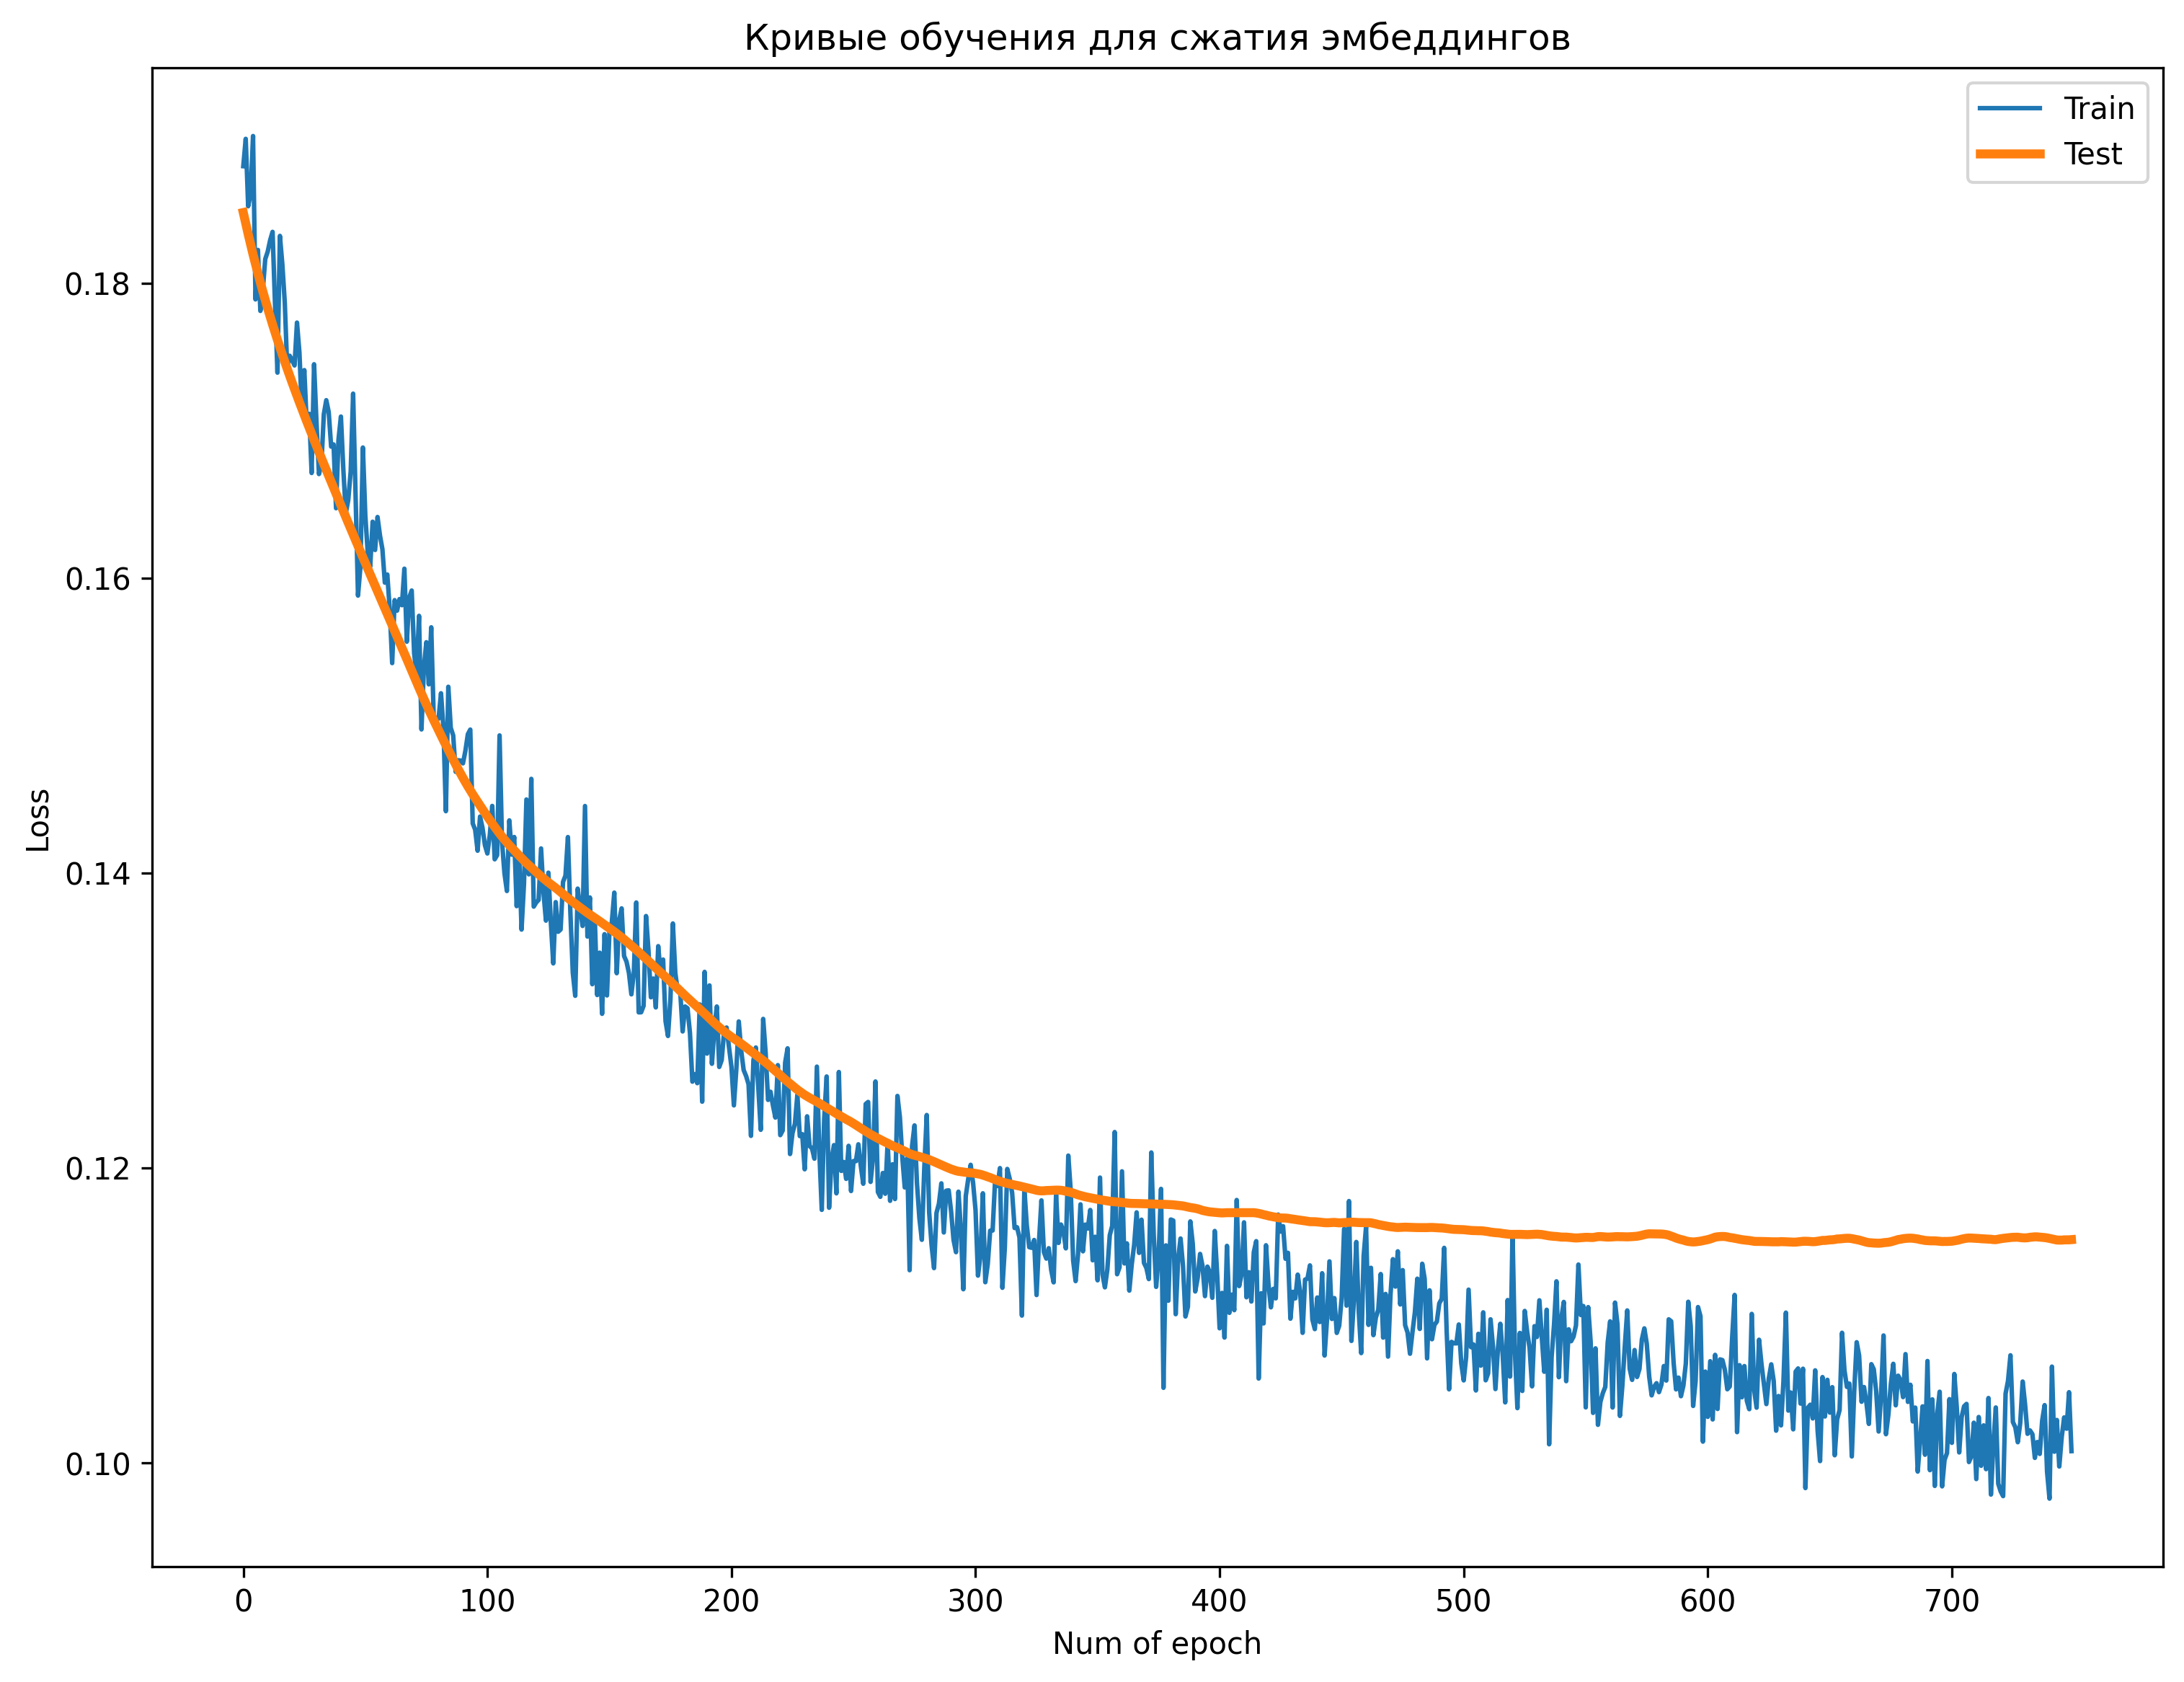

In [17]:
plt.figure(figsize=(12,9), dpi=300)
plt.plot(df_learning_o['loss_train'], label='Train')
plt.plot(df_learning_o['loss_test'], label='Test', linewidth=3)
plt.ylabel('Loss')
plt.xlabel('Num of epoch')
plt.title('Кривые обучения для сжатия эмбеддингов')
plt.legend()

In [18]:
model.eval()
with torch.no_grad():
    compressed_embeddings, _ = model(torch.FloatTensor(embedding))

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(compressed_embeddings.numpy(), labels, train_size=0.8, random_state=52)

Сохраним сжатые эмбеддинги

In [20]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('Y_train.npy', Y_train)
np.save('Y_test.npy', Y_test)

In [21]:
np.save('compressed_embeddings.npy', compressed_embeddings.numpy())

In [22]:
np.save('labels.npy', labels)

ОБРАБОТКА ДАННЫХ НА 9 утра

In [24]:
with open('NEW_DATA.pickle', 'rb') as f:
    NEW_DATA = pkl.load(f)
    new_data, new_label = NEW_DATA['embeddings'], NEW_DATA['labels']

In [25]:
model.eval()
with torch.no_grad():
    new_compressed_embeddings, _ = model(torch.FloatTensor(new_data))
np.save('new_compressed_embeddings.npy', new_compressed_embeddings)
np.save('new_labels.npy', new_label)

In [27]:
new_label

array(['-', '-', '+', '+', '-', '-', '+', '-', '-', '-', '+', '-', '+',
       '+', '-', '+', '-', '+', '+', '-', '-', '-', '+', '+', '+', '+',
       '-', '-', '+', '-', '+', '-', '+', '-', '-', '+', '-', '-', '-',
       '-', '+', '-', '+', '-', '+', '+', '+', '+', '-', '-'],
      dtype=object)